# Imports

In [1]:
!pip install tqdm
!pip install node2vec
!pip install demoji

!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_tree_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_label_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_source_tweet_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_vectors.npy
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_graph.graphml
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/embeddings.pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tqdm
!pip install node2vec
!pip install demoji

!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_tree_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_label_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_source_tweet_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_vectors.npy
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_graph.graphml.xml
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/embeddings.pickle


--2024-06-20 19:04:51--  https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_tree_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41267063 (39M) [text/plain]
Saving to: ‘twitter15_tree_data.csv.1’

twitter15_tree_data 100%[===================>]  39.35M   223MB/s    in 0.2s    

2024-06-20 19:04:51 (223 MB/s) - ‘twitter15_tree_data.csv.1’ saved [41267063/41267063]

--2024-06-20 19:04:51--  https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_label_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

In [4]:
!ls "/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/datas/embs/"
!cp "/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/datas/embs/twitter_15_deb_new_clean.npy" ./twitter_15_deb_new_clean.npy

twitter_15_deb_agg_clean.npy  twitter_15_deb_new_clean_soft.npy  twitter_15_glove_new_clean.npy
twitter_15_deb_new_clean.npy  twitter_15_deb_no_clean.npy	 twitter_16_deb_new_clean.npy


In [5]:
import pandas as pd
import torch
from transformers import DebertaTokenizer, DebertaModel
import numpy as np
import networkx as nx
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import DebertaModel, DebertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Load datas

In [6]:
twitter15_tree_df = pd.read_csv('./twitter15_tree_data.csv')
twitter15_label_df = pd.read_csv('./twitter15_label_data.csv')
twitter15_source_tweet_df = pd.read_csv('./twitter15_source_tweet_data.csv')

tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
deberta_model = DebertaModel.from_pretrained('microsoft/deberta-base')

twitter15_vectors = np.load('./twitter_15_deb_new_clean.npy')

G = nx.DiGraph()
G = nx.read_graphml('./twitter15_graph.graphml.xml')

import pickle
with open('./embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

In [7]:
deb_emb = {}
n2v_emb = {}
label = {}
for idx in range(len(twitter15_vectors)):
  deb_emb[twitter15_source_tweet_df['source_tweet_id'][idx]] = twitter15_vectors[idx]
  n2v_emb[twitter15_source_tweet_df['source_tweet_id'][idx]] = embeddings[str(twitter15_source_tweet_df['source_tweet_id'][idx])]

print(len(deb_emb))
print(len(n2v_emb))

1490
1490


# Split dataset

In [8]:
labels = twitter15_label_df['label'].tolist()
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
#####
deb_emb_array = np.array(list(deb_emb.values()))
n2v_emb_array = np.array(list(n2v_emb.values()))

# Check if arrays have the same length
assert deb_emb_array.shape[0] == n2v_emb_array.shape[0], "Arrays have different lengths!"

# Split arrays into training and testing sets
deb_train, deb_test, n2v_train, n2v_test, y_train, y_test = train_test_split(deb_emb_array, n2v_emb_array, encoded_labels, test_size=0.2, random_state=42)
#####
X_train, X_test, y_train, y_test = train_test_split(twitter15_vectors, encoded_labels, test_size=0.2, random_state=42)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

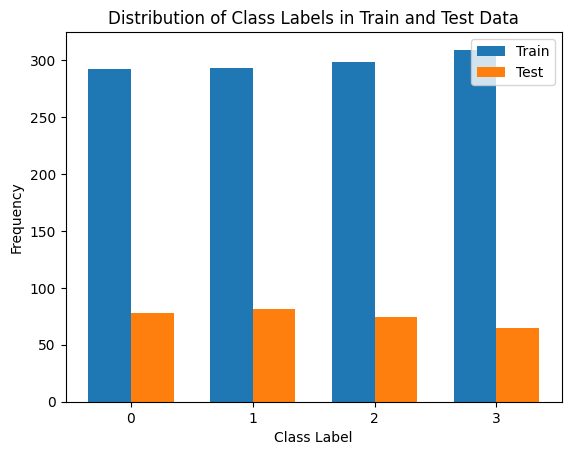

In [ ]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

# Create bar chart
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(train_classes))
train_bars = ax.bar(index, train_counts, bar_width, label='Train')
test_bars = ax.bar(index + bar_width, test_counts, bar_width, label='Test')

ax.set_xlabel('Class Label')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Class Labels in Train and Test Data')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(train_classes)
ax.legend()

plt.show()

In [9]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold


def train_model(model, criterion, optimizer, deb_train, n2v_train, y_train, deb_val, n2v_val, y_val, batch_size, num_epochs):
    train_bar = tqdm(total=num_epochs, position=0, leave=True)
    for epoch in range(num_epochs):
        model.to("cuda")
        model.train()
        running_loss = 0.0
        for i in range(0, len(deb_train), batch_size):
            inputs_deberta = torch.tensor(deb_train[i:i+batch_size], dtype=torch.float32).to("cuda")
            inputs_node = torch.tensor(n2v_train[i:i+batch_size], dtype=torch.float32).to("cuda")
            labels = y_train[i:i+batch_size].clone().detach().to("cuda")

            optimizer.zero_grad()
            outputs = model(inputs_deberta, inputs_node)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(inputs_deberta)
            # train_bar.update(len(inputs_deberta))

        epoch_loss = running_loss / len(deb_train)
        val_loss, val_acc = validate_model(model, criterion, deb_val, n2v_val, y_val, batch_size)
        train_bar.update(1)
        train_bar.set_postfix({'Validation Loss:': f'{val_loss:.4f}',
                               'Validation Accuracy:' : f'{val_acc:.4f}'})

# Used only for the best model
def train_model_with_cv(model, criterion, optimizer, deb_train, n2v_train, y_train, batch_size, num_epochs, n_splits=4):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    total_val_acc = 0.0
    total_val_loss = 0.0

    for train_index, val_index in kf.split(deb_train):
        fold += 1
        print(f"Training on fold {fold}/{n_splits}...")

        train_fold_deb = deb_train[train_index]
        train_fold_n2v = n2v_train[train_index]
        train_fold_y = y_train[train_index]

        val_fold_deb = deb_train[val_index]
        val_fold_n2v = n2v_train[val_index]
        val_fold_y = y_train[val_index]

        train_bar = tqdm(total=num_epochs, position=0, leave=True)
        for epoch in range(num_epochs):
            model.to("cuda")
            model.train()
            running_loss = 0.0
            for i in range(0, len(train_fold_deb), batch_size):
                inputs_deberta = torch.tensor(train_fold_deb[i:i+batch_size], dtype=torch.float32).to("cuda")
                inputs_node = torch.tensor(train_fold_n2v[i:i+batch_size], dtype=torch.float32).to("cuda")
                labels = train_fold_y[i:i+batch_size].clone().detach().to("cuda")

                optimizer.zero_grad()
                outputs = model(inputs_deberta, inputs_node)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * len(inputs_deberta)

            epoch_loss = running_loss / len(train_fold_deb)
            val_loss, val_acc = validate_model(model, criterion, val_fold_deb, val_fold_n2v, val_fold_y, batch_size)

            train_bar.update(1)
            train_bar.set_postfix({'Validation Loss:': f'{val_loss:.4f}', 'Validation Accuracy:' : f'{val_acc:.4f}'})

        total_val_acc += val_acc  # accumulate validation accuracy for averaging later
        total_val_loss += val_loss
        train_bar.close()

    avg_val_acc = total_val_acc / n_splits
    avg_val_loss = total_val_loss / n_splits
    print({'Validation Loss:': f'{avg_val_loss:.4f}', 'Validation Accuracy:' : f'{avg_val_acc:.4f}'})


# Define the validation function
def validate_model(model, criterion, deb_val, n2v_val, y_val, batch_size):
    model.to("cpu")
    model.eval()
    val_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for i in range(0, len(deb_val), batch_size):
            inputs_deberta = torch.tensor(deb_val[i:i+batch_size], dtype=torch.float32)
            inputs_node = torch.tensor(n2v_val[i:i+batch_size], dtype=torch.float32)
            labels = y_val[i:i+batch_size]

            outputs = model(inputs_deberta, inputs_node)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * len(inputs_deberta)
            all_outputs.append(outputs)
            all_labels.extend(labels)

    val_loss /= len(deb_val)
    all_outputs = torch.cat(all_outputs)
    _, predicted = torch.max(all_outputs, 1)
    val_acc = accuracy_score(all_labels, predicted)
    return val_loss, val_acc

# Define the testing function
def test_model(model, deb_test, n2v_test, y_test, batch_size):
    model.eval()
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for i in range(0, len(deb_test), batch_size):
            inputs_deberta = torch.tensor(deb_test[i:i+batch_size], dtype=torch.float32)
            inputs_node = torch.tensor(n2v_test[i:i+batch_size], dtype=torch.float32)
            labels = y_test[i:i+batch_size]

            outputs = model(inputs_deberta, inputs_node)
            all_outputs.append(outputs)
            all_labels.extend(labels)

    all_outputs = torch.cat(all_outputs)
    _, predicted = torch.max(all_outputs, 1)
    acc = accuracy_score(all_labels, predicted)
    precision = precision_score(all_labels, predicted, average=None)
    recall = recall_score(all_labels, predicted, average=None)
    f1score = f1_score(all_labels, predicted, average=None)
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1score}')

    conf_matrix = confusion_matrix(all_labels, predicted)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Models

In [10]:
class TextClassificationModel(nn.Module):
    def __init__(self, deb_dim=768, n2v_dim=64, hidden_size=256, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.lstm = nn.LSTM(input_size=deb_dim,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=num_layers,
                            dropout=dropout)

        self.c1 = torch.nn.Conv1d(n2v_dim, 128, 5)
        self.m1 = torch.nn.MaxPool1d(3)

        self.c2 = torch.nn.Conv1d(128, 64, 3)
        self.m2 = torch.nn.MaxPool1d(3)

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):

        # LSTM processing
        lstm_out, _ = self.lstm(self.do(deberta_embeddings))
        # Convolutional processing
        c1 = self.c1(lstm_out)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)
        c2 = self.m2(c2)

        pooled_out, _ = torch.max(c2, dim=2)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)

        return output

In [11]:
class TextClassificationModel2(nn.Module):
    def __init__(self, deb_dim=768, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel2, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.gru = nn.GRU(input_size=768,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=num_layers,
                            dropout=dropout)

        self.c1 = torch.nn.Conv1d(64, 128, 3)
        self.m1 = torch.nn.MaxPool1d(3)

        self.c2 = torch.nn.Conv1d(128, 64, 3)
        self.m2 = torch.nn.MaxPool1d(3)

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):

        gru_out, _ = self.gru(self.do(deberta_embeddings))

        c1 = self.c1(gru_out)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)

        pooled_out, _ = torch.max(c2, dim=2)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)


        return output

In [12]:
class TextClassificationModel3(nn.Module):
    def __init__(self, deb_dim=768, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel3, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.lstm = nn.LSTM(input_size=832,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=num_layers,
                            dropout=dropout)

        self.c1 = torch.nn.Conv1d(64, 48, 3)
        self.m1 = torch.nn.MaxPool1d(3)

        self.c2 = torch.nn.Conv1d(48, 32, 3)
        self.m2 = torch.nn.MaxPool1d(3)

        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 4)

    def forward(self, deberta_embeddings, node2vec_embeddings):
        deberta_embeddings = self.do(deberta_embeddings)

        combined_embeddings = torch.cat([deberta_embeddings,
                                         node2vec_embeddings.unsqueeze(1).expand(-1, 64, -1)],
                                        dim=2)
        lstm_out, _ = self.lstm(self.do(combined_embeddings))

        c1 = self.c1(lstm_out)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)

        pooled_out, _ = torch.max(c2, dim=2)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)


        return output

In [13]:
class TextClassificationModel4(nn.Module):
    def __init__(self, deb_dim=768, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel4, self).__init__()
        self.do = nn.Dropout(p=0.1)
        self.relu = nn.ReLU()

        self.lstm = nn.GRU(input_size=832,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=num_layers,
                            dropout=dropout)

        self.c1 = torch.nn.Conv1d(64, 256, 3)
        self.m1 = torch.nn.MaxPool1d(3)

        self.c2 = torch.nn.Conv1d(256, 128, 3)
        self.m2 = torch.nn.MaxPool1d(3)

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, deberta_embeddings, node2vec_embeddings):

        deberta_embeddings = self.do(deberta_embeddings)

        combined_embeddings = torch.cat([deberta_embeddings,
                                         node2vec_embeddings.unsqueeze(1).expand(-1, 64, -1)],
                                        dim=2)
        lstm_out, _ = self.lstm(self.do(combined_embeddings))

        c1 = self.c1(lstm_out)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)

        pooled_out, _ = torch.max(c2, dim=2)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)


        return output

In [14]:

class TextClassificationModel5(nn.Module):
    def __init__(self, deb_dim=768, n2v_dim=64, hidden_size=256, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel5, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        # Convolutional Layers
        self.c1 = nn.Conv1d(in_channels=deb_dim, out_channels=128, kernel_size=5)
        self.m1 = nn.MaxPool1d(kernel_size=3)

        self.c2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3)
        self.m2 = nn.MaxPool1d(kernel_size=3)

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size=64,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=True,
                            batch_first=True,
                            dropout=dropout)

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=hidden_size*2, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):
        # Convolutional processing
        deberta_embeddings = deberta_embeddings.permute(0, 2, 1)

        c1 = self.c1(deberta_embeddings)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)
        c2 = self.m2(c2)

        # Prepare for LSTM (batch_size, sequence_length, channels)
        c2 = c2.permute(0, 2, 1)

        # LSTM processing
        lstm_out, _ = self.lstm(self.do(c2))

        # Pooling and Flattening
        pooled_out, _ = torch.max(lstm_out, dim=1)

        # Fully connected layers
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)

        return output

In [15]:

class TextClassificationModel6(nn.Module):
    def __init__(self, deb_dim=768, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel6, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        # Convolutional Layers
        self.c1 = nn.Conv1d(in_channels=deb_dim, out_channels=64, kernel_size=3)
        self.m1 = nn.MaxPool1d(kernel_size=3)

        self.c2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3)
        self.m2 = nn.MaxPool1d(kernel_size=3)

        # BiGRU Layer
        self.gru = nn.GRU(input_size=32,
                          hidden_size=hidden_size,
                          bidirectional=True,
                          batch_first=True,
                          num_layers=num_layers,
                          dropout=dropout)

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=hidden_size*2, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):
        # Convolutional processing
        deberta_embeddings = deberta_embeddings.permute(0, 2, 1)

        c1 = self.c1(deberta_embeddings)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)
        c2 = self.m2(c2)

        # Prepare for GRU (batch_size, sequence_length, channels)
        c2 = c2.permute(0, 2, 1)

        # BiGRU processing
        gru_out, _ = self.gru(self.do(c2))

        # Pooling and Flattening
        pooled_out, _ = torch.max(gru_out, dim=1)

        # Fully connected layers
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)

        return output

In [16]:
class TextClassificationModel7(nn.Module):
    def __init__(self, deb_dim=768, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel7, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.cnn1 = nn.Conv1d(in_channels=832, out_channels=128, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(input_size=64,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=num_layers,
                            dropout=dropout)

        self.fc1 = nn.Linear(hidden_size * 2, 16)
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):
        deberta_embeddings = self.do(deberta_embeddings)

        combined_embeddings = torch.cat([deberta_embeddings,
                                         node2vec_embeddings.unsqueeze(1).expand(-1, 64, -1)],
                                        dim=2)
        # CNN layers
        cnn_out = self.cnn1(combined_embeddings.permute(0, 2, 1))
        cnn_out = self.relu(cnn_out)
        cnn_out = self.maxpool(cnn_out)

        cnn_out = self.cnn2(cnn_out)
        cnn_out = self.relu(cnn_out)
        cnn_out = self.maxpool(cnn_out)

        # Permute back to (batch, seq_len, feature)
        cnn_out = cnn_out.permute(0, 2, 1)

        # LSTM layers
        lstm_out, _ = self.lstm(self.do(cnn_out))

        # Max pooling over the sequence length
        pooled_out, _ = torch.max(lstm_out, dim=1)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)


        return output

In [17]:
class TextClassificationModel8(nn.Module):
    def __init__(self, deb_dim=768, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel8, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.cnn1 = nn.Conv1d(in_channels=832, out_channels=256, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.gru = nn.GRU(input_size=128,
                          hidden_size=hidden_size,
                          bidirectional=True,
                          batch_first=True,
                          num_layers=num_layers,
                          dropout=dropout)

        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):

        deberta_embeddings = self.do(deberta_embeddings)

        combined_embeddings = torch.cat([deberta_embeddings,
                                         node2vec_embeddings.unsqueeze(1).expand(-1, 64, -1)],
                                        dim=2)
        cnn_out = self.cnn1(combined_embeddings.permute(0, 2, 1))
        cnn_out = self.relu(cnn_out)
        cnn_out = self.maxpool(cnn_out)

        cnn_out = self.cnn2(cnn_out)
        cnn_out = self.relu(cnn_out)
        cnn_out = self.maxpool(cnn_out)

        # Permute back to (batch, seq_len, feature)
        cnn_out = cnn_out.permute(0, 2, 1)

        # GRU layers
        gru_out, _ = self.gru(self.do(cnn_out))

        pooled_out, _ = torch.max(gru_out, dim=1)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)


        return output

# Grid Validation

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, ParameterGrid

def custom_scorer(estimator, X, y, batch_size):
    deb_val, n2v_val = X
    y_val = y
    criterion = nn.CrossEntropyLoss()

    _, val_acc = validate_model(estimator, criterion, deb_val, n2v_val, y_val, batch_size)
    return val_acc

def model_fit_predict(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid, cv=3):
    best_score = 0.0
    best_params = None

    for params in ParameterGrid(param_grid):
        # Split the training data into training and validation sets
        deb_train_split, deb_val_split, n2v_train_split, n2v_val_split, y_train_split, y_val_split = train_test_split(
            deb_train, n2v_train, y_train, test_size=0.2, random_state=42
        )

        model = TextClassificationModel(
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        )

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_model(model, criterion, optimizer, deb_train_split, n2v_train_split, y_train_split, deb_val_split, n2v_val_split, y_val_split, params['batch_size'], params['num_epochs'])

        score = custom_scorer(model, (deb_val_split, n2v_val_split), y_val_split, params['batch_size'])
        if score > best_score:
            best_score = score
            best_params = params

    print(f'Best parameters: {best_params}')
    print(f'Best validation accuracy: {best_score:.4f}')

    best_model = TextClassificationModel(
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
    train_model(best_model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, best_params['batch_size'], best_params['num_epochs'])

    test_model(best_model, deb_test, n2v_test, y_test, best_params['batch_size'])

# Define hyperparameter grid
param_grid = {
    'hidden_size': [256, 512],
    'num_layers': [3, 4],
    'dropout': [0.1, 0.2],
    'lr': [0.0001, 0.0003],
    'num_epochs': [30, 40],
    'batch_size': [24]
}

# Perform grid search
#model_fit_predict(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid)


* M1 - BiLSTM + Deb - 72% or more
* M2 - BiGRU + Deb - 73% or more
* M3 - BiLSTM + Deb + N2v - 71% or more
* M4 - BiGRU + Deb + N2v - 72% or more

Length 64
* M1 - BiLSTM + Deb - 74% or more
* M2 - BiGRU + Deb - 76% or more
* M3 - BiLSTM + Deb + N2v - 68% or more
* M4 - BiGRU + Deb + N2v - 70% or more

M1:
* 40 epochs: 76% ac lr 0.0003 weight_decay=0.0002
M3 fara wd si cu batch size 24



# Models saved for later

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24

model =  TextClassificationModel8(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )
model.to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
train_model_with_cv(model, criterion, optimizer, deb_train, n2v_train, y_train, 24, 40)

Training on fold 1/4...


100%|██████████| 40/40 [01:44<00:00,  2.62s/it, Validation Loss:=1.6992, Validation Accuracy:=0.7148]


Training on fold 2/4...


100%|██████████| 40/40 [01:33<00:00,  2.34s/it, Validation Loss:=0.0675, Validation Accuracy:=0.9899]


Training on fold 3/4...


100%|██████████| 40/40 [01:33<00:00,  2.35s/it, Validation Loss:=0.0612, Validation Accuracy:=0.9899]


Training on fold 4/4...


100%|██████████| 40/40 [01:33<00:00,  2.34s/it, Validation Loss:=0.0589, Validation Accuracy:=0.9866]

{'Validation Loss:': '0.4717', 'Validation Accuracy:': '0.9203'}


In [ ]:
model_save_path = '/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/model8.pth'
torch.save(model.state_dict(), model_save_path)

In [18]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24

model =  TextClassificationModel(
        hidden_size=256,
        num_layers=3,
        dropout=0.2
    )
model.to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
train_model_with_cv(model, criterion, optimizer, deb_train, n2v_train, y_train, 24, 30)
model_save_path = '/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/model1.pth'
torch.save(model.state_dict(), model_save_path)

Training on fold 1/4...


100%|██████████| 30/30 [01:06<00:00,  2.22s/it, Validation Loss:=1.7247, Validation Accuracy:=0.6409]


Training on fold 2/4...


100%|██████████| 30/30 [01:03<00:00,  2.12s/it, Validation Loss:=0.0538, Validation Accuracy:=0.9866]


Training on fold 3/4...


100%|██████████| 30/30 [01:05<00:00,  2.18s/it, Validation Loss:=0.1221, Validation Accuracy:=0.9530]


Training on fold 4/4...


100%|██████████| 30/30 [01:04<00:00,  2.15s/it, Validation Loss:=0.0003, Validation Accuracy:=1.0000]

{'Validation Loss:': '0.4752', 'Validation Accuracy:': '0.8951'}


In [19]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24

model =  TextClassificationModel2(
        hidden_size=512,
        num_layers=3,
        dropout=0.1
    )
model.to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
train_model_with_cv(model, criterion, optimizer, deb_train, n2v_train, y_train, 24, 30)
model_save_path = '/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/model2.pth'
torch.save(model.state_dict(), model_save_path)

Training on fold 1/4...


100%|██████████| 30/30 [02:46<00:00,  5.55s/it, Validation Loss:=1.7081, Validation Accuracy:=0.6544]


Training on fold 2/4...


100%|██████████| 30/30 [02:46<00:00,  5.57s/it, Validation Loss:=0.0387, Validation Accuracy:=0.9899]


Training on fold 3/4...


100%|██████████| 30/30 [02:46<00:00,  5.56s/it, Validation Loss:=0.0463, Validation Accuracy:=0.9933]


Training on fold 4/4...


100%|██████████| 30/30 [02:46<00:00,  5.56s/it, Validation Loss:=0.0002, Validation Accuracy:=1.0000]

{'Validation Loss:': '0.4483', 'Validation Accuracy:': '0.9094'}


In [20]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24

model =  TextClassificationModel3(
        hidden_size=256,
        num_layers=4,
        dropout=0.2
    )
model.to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
train_model_with_cv(model, criterion, optimizer, deb_train, n2v_train, y_train, 24, 40)
model_save_path = '/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/model3.pth'
torch.save(model.state_dict(), model_save_path)

Training on fold 1/4...


100%|██████████| 40/40 [01:50<00:00,  2.75s/it, Validation Loss:=1.7628, Validation Accuracy:=0.7181]


Training on fold 2/4...


100%|██████████| 40/40 [01:50<00:00,  2.77s/it, Validation Loss:=0.0429, Validation Accuracy:=0.9933]


Training on fold 3/4...


100%|██████████| 40/40 [01:51<00:00,  2.79s/it, Validation Loss:=0.0068, Validation Accuracy:=0.9966]


Training on fold 4/4...


100%|██████████| 40/40 [01:50<00:00,  2.77s/it, Validation Loss:=0.0175, Validation Accuracy:=0.9966]

{'Validation Loss:': '0.4575', 'Validation Accuracy:': '0.9262'}


In [21]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24

model =  TextClassificationModel4(
        hidden_size=512,
        num_layers=3,
        dropout=0.1
    )
model.to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
train_model_with_cv(model, criterion, optimizer, deb_train, n2v_train, y_train, 24, 30)
model_save_path = '/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/model4.pth'
torch.save(model.state_dict(), model_save_path)

Training on fold 1/4...


100%|██████████| 30/30 [03:04<00:00,  6.15s/it, Validation Loss:=2.2743, Validation Accuracy:=0.6107]


Training on fold 2/4...


100%|██████████| 30/30 [03:03<00:00,  6.11s/it, Validation Loss:=0.1034, Validation Accuracy:=0.9765]


Training on fold 3/4...


100%|██████████| 30/30 [03:02<00:00,  6.08s/it, Validation Loss:=0.0080, Validation Accuracy:=0.9966]


Training on fold 4/4...


100%|██████████| 30/30 [03:04<00:00,  6.15s/it, Validation Loss:=0.0129, Validation Accuracy:=0.9966]

{'Validation Loss:': '0.5997', 'Validation Accuracy:': '0.8951'}


In [22]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24

model =  TextClassificationModel5(
        hidden_size=256,
        num_layers=4,
        dropout=0.1
    )
model.to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
train_model_with_cv(model, criterion, optimizer, deb_train, n2v_train, y_train, 24, 30)
model_save_path = '/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/model5.pth'
torch.save(model.state_dict(), model_save_path)

Training on fold 1/4...


100%|██████████| 30/30 [00:18<00:00,  1.60it/s, Validation Loss:=1.7128, Validation Accuracy:=0.6779]


Training on fold 2/4...


100%|██████████| 30/30 [00:17<00:00,  1.68it/s, Validation Loss:=0.1121, Validation Accuracy:=0.9664]


Training on fold 3/4...


100%|██████████| 30/30 [00:18<00:00,  1.62it/s, Validation Loss:=0.0002, Validation Accuracy:=1.0000]


Training on fold 4/4...


100%|██████████| 30/30 [00:17<00:00,  1.67it/s, Validation Loss:=0.0001, Validation Accuracy:=1.0000]

{'Validation Loss:': '0.4563', 'Validation Accuracy:': '0.9111'}


In [23]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24

model =  TextClassificationModel6(
        hidden_size=256,
        num_layers=4,
        dropout=0.2
    )
model.to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
train_model_with_cv(model, criterion, optimizer, deb_train, n2v_train, y_train, 24, 40)
model_save_path = '/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/model6.pth'
torch.save(model.state_dict(), model_save_path)

Training on fold 1/4...


100%|██████████| 40/40 [00:21<00:00,  1.89it/s, Validation Loss:=2.2345, Validation Accuracy:=0.6074]


Training on fold 2/4...


100%|██████████| 40/40 [00:20<00:00,  1.96it/s, Validation Loss:=0.1091, Validation Accuracy:=0.9732]


Training on fold 3/4...


100%|██████████| 40/40 [00:20<00:00,  1.93it/s, Validation Loss:=0.0408, Validation Accuracy:=0.9866]


Training on fold 4/4...


100%|██████████| 40/40 [00:20<00:00,  1.94it/s, Validation Loss:=0.0783, Validation Accuracy:=0.9732]

{'Validation Loss:': '0.6157', 'Validation Accuracy:': '0.8851'}


In [24]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24

model =  TextClassificationModel7(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )
model.to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
train_model_with_cv(model, criterion, optimizer, deb_train, n2v_train, y_train, 24, 40)
model_save_path = '/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/model7.pth'
torch.save(model.state_dict(), model_save_path)

Training on fold 1/4...


100%|██████████| 40/40 [01:34<00:00,  2.36s/it, Validation Loss:=1.5628, Validation Accuracy:=0.6678]


Training on fold 2/4...


100%|██████████| 40/40 [01:33<00:00,  2.35s/it, Validation Loss:=0.1850, Validation Accuracy:=0.9564]


Training on fold 3/4...


100%|██████████| 40/40 [01:34<00:00,  2.37s/it, Validation Loss:=0.0058, Validation Accuracy:=1.0000]


Training on fold 4/4...


100%|██████████| 40/40 [01:33<00:00,  2.34s/it, Validation Loss:=0.0235, Validation Accuracy:=0.9966]

{'Validation Loss:': '0.4443', 'Validation Accuracy:': '0.9052'}


# Testing different preprocessings
Soft

100%|██████████| 40/40 [01:49<00:00,  2.73s/it, Validation Loss:=1.2869, Validation Accuracy:=0.7617]


Accuracy: 0.7617
Precision: [0.83333333 0.65048544 0.86111111 0.75438596]
Recall: [0.70512821 0.82716049 0.83783784 0.66153846]
F1 Score: [0.76388889 0.72826087 0.84931507 0.70491803]


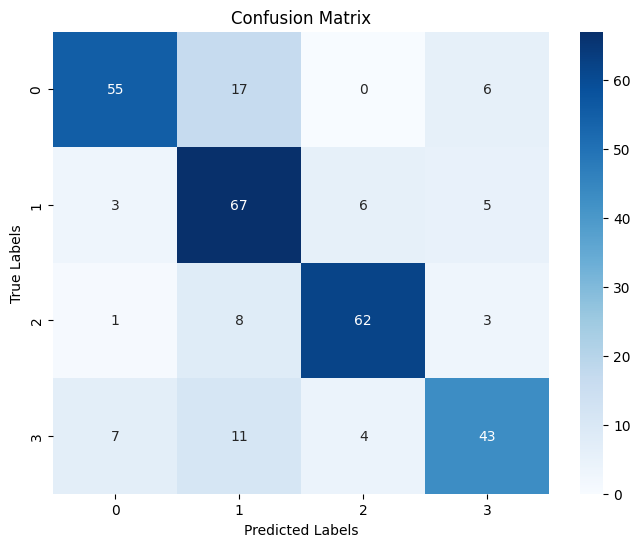

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24


model =  TextClassificationModel8(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )
model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

train_model(model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, batch_size, num_epochs)

test_model(model, deb_test, n2v_test, y_test, batch_size)


No clean

100%|██████████| 40/40 [01:37<00:00,  2.44s/it, Validation Loss:=1.3801, Validation Accuracy:=0.7483]


Accuracy: 0.7483
Precision: [0.7260274  0.70212766 0.86111111 0.71186441]
Recall: [0.67948718 0.81481481 0.83783784 0.64615385]
F1 Score: [0.70198675 0.75428571 0.84931507 0.67741935]


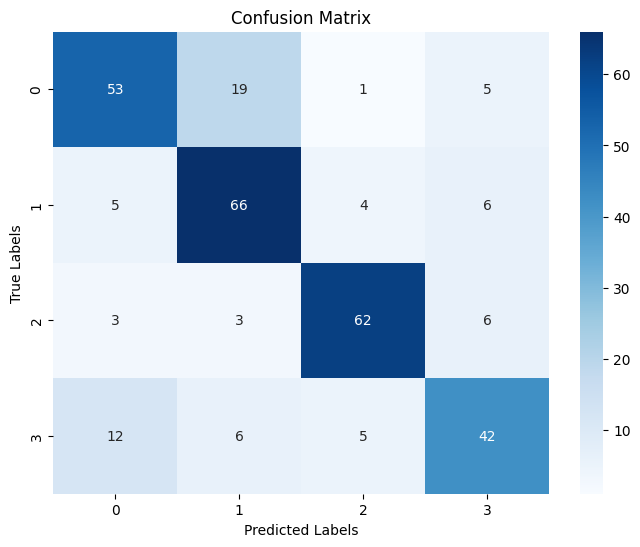

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24


model =  TextClassificationModel8(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )

model.to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)


train_model(model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, batch_size, num_epochs)

test_model(model, deb_test, n2v_test, y_test, batch_size)


Aggressive Clean

100%|██████████| 40/40 [01:49<00:00,  2.75s/it, Validation Loss:=1.3226, Validation Accuracy:=0.7450]


Accuracy: 0.7450
Precision: [0.6875     0.80821918 0.79746835 0.68181818]
Recall: [0.70512821 0.72839506 0.85135135 0.69230769]
F1 Score: [0.69620253 0.76623377 0.82352941 0.6870229 ]


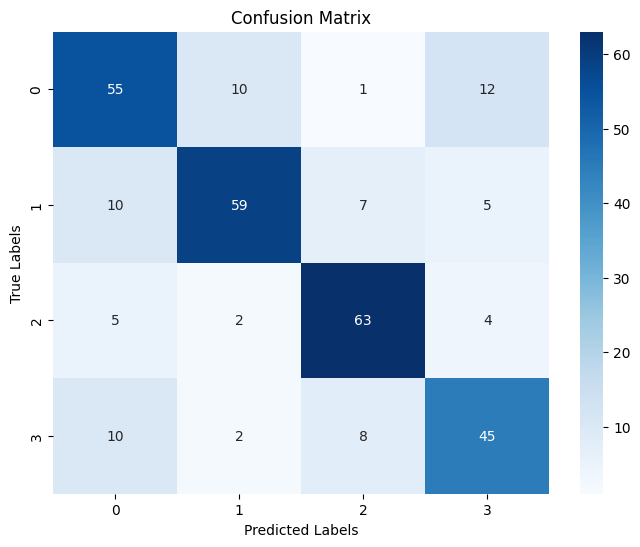

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 24

model =  TextClassificationModel8(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

train_model(model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, batch_size, num_epochs)

test_model(model, deb_test, n2v_test, y_test, batch_size)


# Grid Validation for each model

100%|██████████| 40/40 [04:24<00:00,  6.60s/it, Validation Loss:=1.8761, Validation Accuracy:=0.6444]


Best parameters: {'batch_size': 24, 'dropout': 0.1, 'hidden_size': 512, 'lr': 0.0003, 'num_epochs': 30, 'num_layers': 3}
Best validation accuracy: 0.6904


100%|██████████| 30/30 [03:09<00:00,  6.32s/it, Validation Loss:=1.4303, Validation Accuracy:=0.7450]


Accuracy: 0.7450
Precision: [0.79032258 0.67021277 0.78205128 0.765625  ]
Recall: [0.62820513 0.77777778 0.82432432 0.75384615]
F1 Score: [0.7        0.72       0.80263158 0.75968992]


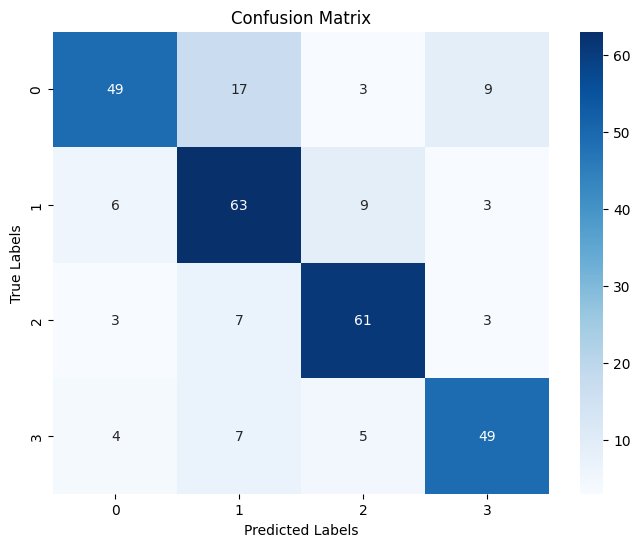

In [ ]:
def model_fit_predict2(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid, cv=3):
    best_score = 0.0
    best_params = None

    for params in ParameterGrid(param_grid):
        # Split the training data into training and validation sets
        deb_train_split, deb_val_split, n2v_train_split, n2v_val_split, y_train_split, y_val_split = train_test_split(
            deb_train, n2v_train, y_train, test_size=0.2, random_state=42
        )

        model = TextClassificationModel2(
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        )

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_model(model, criterion, optimizer, deb_train_split, n2v_train_split, y_train_split, deb_val_split, n2v_val_split, y_val_split, params['batch_size'], params['num_epochs'])

        score = custom_scorer(model, (deb_val_split, n2v_val_split), y_val_split, params['batch_size'])
        if score > best_score:
            best_score = score
            best_params = params

    print(f'Best parameters: {best_params}')
    print(f'Best validation accuracy: {best_score:.4f}')

    best_model = TextClassificationModel2(
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
    train_model(best_model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, best_params['batch_size'], best_params['num_epochs'])

    test_model(best_model, deb_test, n2v_test, y_test, params['batch_size'])

model_fit_predict2(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid)



Use a CNN-BiLSTM network and the DeBERTa and DeepWalk vectors to classify the data (in harmful or not harmful) - use TensorFlow + Keras OR Pytorch

100%|██████████| 40/40 [05:17<00:00,  7.93s/it, Validation Loss:=2.1652, Validation Accuracy:=0.6234]


Best parameters: {'batch_size': 24, 'dropout': 0.2, 'hidden_size': 256, 'lr': 0.0003, 'num_epochs': 40, 'num_layers': 4}
Best validation accuracy: 0.7029


100%|██████████| 40/40 [02:08<00:00,  3.21s/it, Validation Loss:=1.7420, Validation Accuracy:=0.7248]


Accuracy: 0.7248
Precision: [0.75757576 0.75       0.72727273 0.66176471]
Recall: [0.64102564 0.7037037  0.86486486 0.69230769]
F1 Score: [0.69444444 0.72611465 0.79012346 0.67669173]


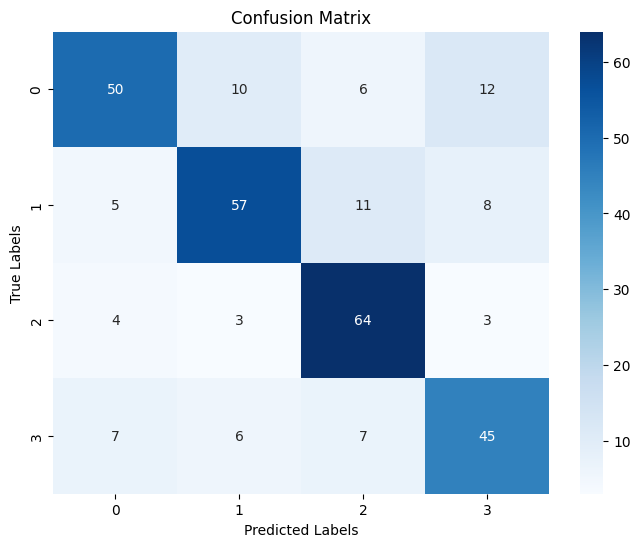

In [ ]:
def model_fit_predict3(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid, cv=3):
    best_score = 0.0
    best_params = None

    for params in ParameterGrid(param_grid):
        # Split the training data into training and validation sets
        deb_train_split, deb_val_split, n2v_train_split, n2v_val_split, y_train_split, y_val_split = train_test_split(
            deb_train, n2v_train, y_train, test_size=0.2, random_state=42
        )

        model = TextClassificationModel3(
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        )

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_model(model, criterion, optimizer, deb_train_split, n2v_train_split, y_train_split, deb_val_split, n2v_val_split, y_val_split, params['batch_size'], params['num_epochs'])

        score = custom_scorer(model, (deb_val_split, n2v_val_split), y_val_split, params['batch_size'])
        if score > best_score:
            best_score = score
            best_params = params

    print(f'Best parameters: {best_params}')
    print(f'Best validation accuracy: {best_score:.4f}')

    best_model = TextClassificationModel3(
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
    train_model(best_model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, best_params['batch_size'], best_params['num_epochs'])

    test_model(best_model, deb_test, n2v_test, y_test, params['batch_size'])

model_fit_predict3(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid)



100%|██████████| 40/40 [04:44<00:00,  7.12s/it, Validation Loss:=2.0057, Validation Accuracy:=0.6778]


Best parameters: {'batch_size': 24, 'dropout': 0.1, 'hidden_size': 512, 'lr': 0.0003, 'num_epochs': 40, 'num_layers': 4}
Best validation accuracy: 0.6904


100%|██████████| 40/40 [05:56<00:00,  8.92s/it, Validation Loss:=1.6005, Validation Accuracy:=0.7282]


Accuracy: 0.7282
Precision: [0.76470588 0.60714286 0.88405797 0.73469388]
Recall: [0.66666667 0.83950617 0.82432432 0.55384615]
F1 Score: [0.71232877 0.70466321 0.85314685 0.63157895]


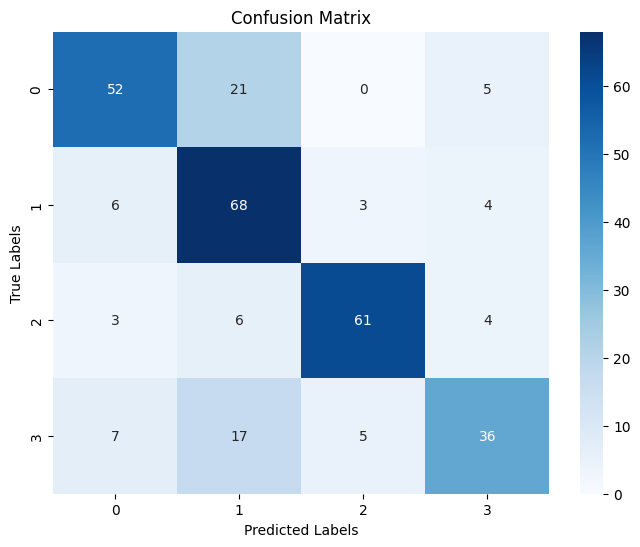

In [ ]:
def model_fit_predict4(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid, cv=3):
    best_score = 0.0
    best_params = None

    for params in ParameterGrid(param_grid):
        # Split the training data into training and validation sets
        deb_train_split, deb_val_split, n2v_train_split, n2v_val_split, y_train_split, y_val_split = train_test_split(
            deb_train, n2v_train, y_train, test_size=0.2, random_state=42
        )

        model = TextClassificationModel4(
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        )

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_model(model, criterion, optimizer, deb_train_split, n2v_train_split, y_train_split, deb_val_split, n2v_val_split, y_val_split, params['batch_size'], params['num_epochs'])

        score = custom_scorer(model, (deb_val_split, n2v_val_split), y_val_split, params['batch_size'])
        if score > best_score:
            best_score = score
            best_params = params

    print(f'Best parameters: {best_params}')
    print(f'Best validation accuracy: {best_score:.4f}')

    best_model = TextClassificationModel4(
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
    train_model(best_model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, best_params['batch_size'], best_params['num_epochs'])

    test_model(best_model, deb_test, n2v_test, y_test, params['batch_size'])

model_fit_predict4(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid)



100%|██████████| 40/40 [00:51<00:00,  1.29s/it, Validation Loss:=1.8051, Validation Accuracy:=0.5690]


Best parameters: {'batch_size': 24, 'dropout': 0.2, 'hidden_size': 512, 'lr': 0.0003, 'num_epochs': 30, 'num_layers': 4}
Best validation accuracy: 0.6653


100%|██████████| 30/30 [00:47<00:00,  1.58s/it, Validation Loss:=1.9486, Validation Accuracy:=0.6913]


Accuracy: 0.6913
Precision: [0.86       0.5754717  0.93103448 0.57142857]
Recall: [0.55128205 0.75308642 0.72972973 0.73846154]
F1 Score: [0.671875   0.65240642 0.81818182 0.6442953 ]


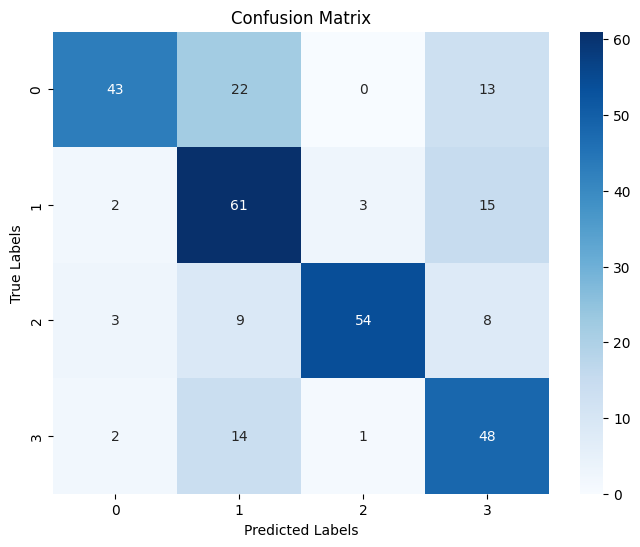

In [ ]:
def model_fit_predict5(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid, cv=3):
    best_score = 0.0
    best_params = None

    for params in ParameterGrid(param_grid):
        # Split the training data into training and validation sets
        deb_train_split, deb_val_split, n2v_train_split, n2v_val_split, y_train_split, y_val_split = train_test_split(
            deb_train, n2v_train, y_train, test_size=0.2, random_state=42
        )

        model = TextClassificationModel5(
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        )

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_model(model, criterion, optimizer, deb_train_split, n2v_train_split, y_train_split, deb_val_split, n2v_val_split, y_val_split, params['batch_size'], params['num_epochs'])

        score = custom_scorer(model, (deb_val_split, n2v_val_split), y_val_split, params['batch_size'])
        if score > best_score:
            best_score = score
            best_params = params

    print(f'Best parameters: {best_params}')
    print(f'Best validation accuracy: {best_score:.4f}')

    best_model = TextClassificationModel5(
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
    train_model(best_model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, best_params['batch_size'], best_params['num_epochs'])

    test_model(best_model, deb_test, n2v_test, y_test, params['batch_size'])

model_fit_predict5(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid)



100%|██████████| 40/40 [00:43<00:00,  1.08s/it, Validation Loss:=1.3850, Validation Accuracy:=0.2971]


Best parameters: {'batch_size': 24, 'dropout': 0.2, 'hidden_size': 256, 'lr': 0.0003, 'num_epochs': 40, 'num_layers': 4}
Best validation accuracy: 0.6527


100%|██████████| 40/40 [00:25<00:00,  1.56it/s, Validation Loss:=1.6768, Validation Accuracy:=0.6846]


Accuracy: 0.6846
Precision: [0.83673469 0.63366337 0.64556962 0.69565217]
Recall: [0.52564103 0.79012346 0.68918919 0.73846154]
F1 Score: [0.64566929 0.7032967  0.66666667 0.71641791]


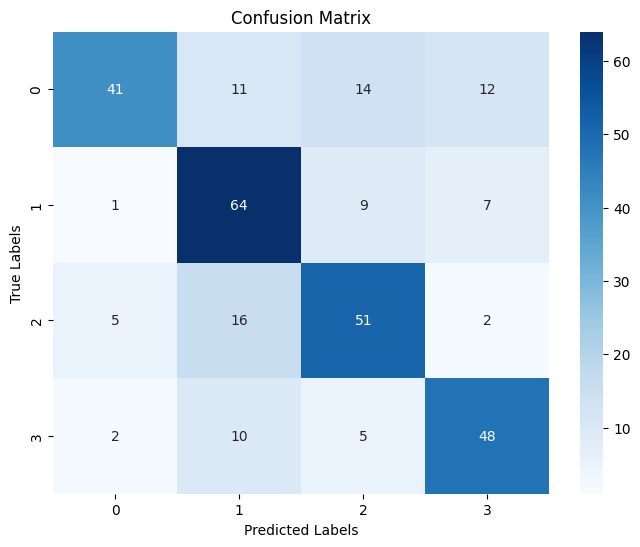

In [ ]:
def model_fit_predict6(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid, cv=3):
    best_score = 0.0
    best_params = None

    for params in ParameterGrid(param_grid):
        # Split the training data into training and validation sets
        deb_train_split, deb_val_split, n2v_train_split, n2v_val_split, y_train_split, y_val_split = train_test_split(
            deb_train, n2v_train, y_train, test_size=0.2, random_state=42
        )

        model = TextClassificationModel6(
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        )

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_model(model, criterion, optimizer, deb_train_split, n2v_train_split, y_train_split, deb_val_split, n2v_val_split, y_val_split, params['batch_size'], params['num_epochs'])

        score = custom_scorer(model, (deb_val_split, n2v_val_split), y_val_split, params['batch_size'])
        if score > best_score:
            best_score = score
            best_params = params

    print(f'Best parameters: {best_params}')
    print(f'Best validation accuracy: {best_score:.4f}')

    best_model = TextClassificationModel6(
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
    train_model(best_model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, best_params['batch_size'], best_params['num_epochs'])

    test_model(best_model, deb_test, n2v_test, y_test, params['batch_size'])

model_fit_predict6(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid)



100%|██████████| 40/40 [01:16<00:00,  1.92s/it, Validation Loss:=1.6509, Validation Accuracy:=0.6778]


Best parameters: {'batch_size': 24, 'dropout': 0.2, 'hidden_size': 512, 'lr': 0.0003, 'num_epochs': 40, 'num_layers': 4}
Best validation accuracy: 0.6778


100%|██████████| 40/40 [01:35<00:00,  2.40s/it, Validation Loss:=1.7904, Validation Accuracy:=0.6879]


Accuracy: 0.6879
Precision: [0.82978723 0.62921348 0.7875     0.57317073]
Recall: [0.5        0.69135802 0.85135135 0.72307692]
F1 Score: [0.624      0.65882353 0.81818182 0.63945578]


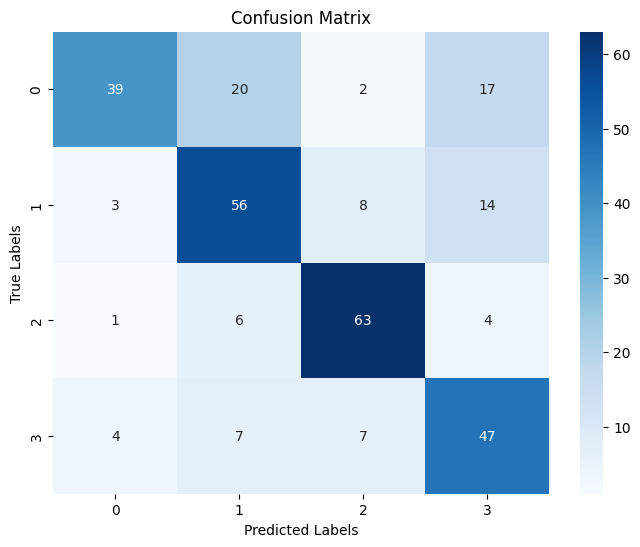

In [ ]:
def model_fit_predict7(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid, cv=3):
    best_score = 0.0
    best_params = None

    for params in ParameterGrid(param_grid):
        # Split the training data into training and validation sets
        deb_train_split, deb_val_split, n2v_train_split, n2v_val_split, y_train_split, y_val_split = train_test_split(
            deb_train, n2v_train, y_train, test_size=0.2, random_state=42
        )

        model = TextClassificationModel7(
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        )

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_model(model, criterion, optimizer, deb_train_split, n2v_train_split, y_train_split, deb_val_split, n2v_val_split, y_val_split, params['batch_size'], params['num_epochs'])

        score = custom_scorer(model, (deb_val_split, n2v_val_split), y_val_split, params['batch_size'])
        if score > best_score:
            best_score = score
            best_params = params

    print(f'Best parameters: {best_params}')
    print(f'Best validation accuracy: {best_score:.4f}')

    best_model = TextClassificationModel7(
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
    train_model(best_model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, best_params['batch_size'], best_params['num_epochs'])

    test_model(best_model, deb_test, n2v_test, y_test, params['batch_size'])

model_fit_predict7(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid)



100%|██████████| 40/40 [01:24<00:00,  2.10s/it, Validation Loss:=1.6397, Validation Accuracy:=0.7197]


Best parameters: {'batch_size': 24, 'dropout': 0.2, 'hidden_size': 512, 'lr': 0.0003, 'num_epochs': 40, 'num_layers': 4}
Best validation accuracy: 0.7197


100%|██████████| 40/40 [01:44<00:00,  2.61s/it, Validation Loss:=1.4135, Validation Accuracy:=0.7584]


Accuracy: 0.7584
Precision: [0.72151899 0.72941176 0.86956522 0.72307692]
Recall: [0.73076923 0.7654321  0.81081081 0.72307692]
F1 Score: [0.72611465 0.74698795 0.83916084 0.72307692]


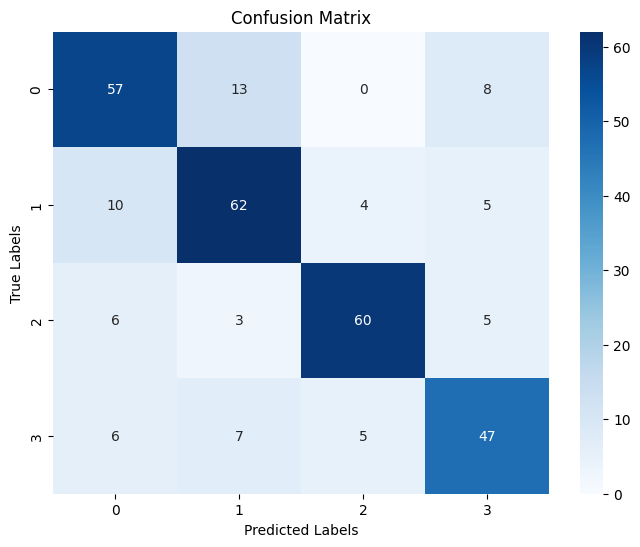

In [ ]:
def model_fit_predict8(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid, cv=3):
    best_score = 0.0
    best_params = None

    for params in ParameterGrid(param_grid):
        # Split the training data into training and validation sets
        deb_train_split, deb_val_split, n2v_train_split, n2v_val_split, y_train_split, y_val_split = train_test_split(
            deb_train, n2v_train, y_train, test_size=0.2, random_state=42
        )

        model = TextClassificationModel8(
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        )

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_model(model, criterion, optimizer, deb_train_split, n2v_train_split, y_train_split, deb_val_split, n2v_val_split, y_val_split, params['batch_size'], params['num_epochs'])

        score = custom_scorer(model, (deb_val_split, n2v_val_split), y_val_split, params['batch_size'])
        if score > best_score:
            best_score = score
            best_params = params

    print(f'Best parameters: {best_params}')
    print(f'Best validation accuracy: {best_score:.4f}')

    best_model = TextClassificationModel8(
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
    train_model(best_model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, best_params['batch_size'], best_params['num_epochs'])

    test_model(best_model, deb_test, n2v_test, y_test, params['batch_size'])

model_fit_predict8(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid)



# Immunization

In [ ]:
print(G.nodes())

['715515982584881152', '691809004356501505', '767223774072676354', '495366618818830336', '520284654755381249', '505369323922522113', '650952376954650629', '530017051025604609', '489798752438583297', '693160939802214400', '682629960826224646', '551097831851687938', '356407105953071107', '693240976970752004', '547514662695469057', '525024066152169473', '519078654635409410', '529747368087126019', '500279189405433858', '508002575858561024', '692463948076093440', '692734579141185536', '693855615618322432', '693071700200722433', '693214543615561729', '689922870689009664', '516361247223058432', '524925600318754816', '692692529779707904', '716092408920936448', '516386101766782976', '748543642323783681', '687639526282498049', '692742353736568833', '651786568592658433', '742055437932040193', '766358933296517121', '752965545528528898', '727834854931435522', '691064699853606913', '706665777332621314', '560442390805090307', '689208632148365314', '364383457545162754', '542423103834296323', '69211383

In [ ]:
print(deb_emb.keys())

dict_keys([731166399389962242, 714598641827246081, 691809004356501505, 693204708933160960, 551099691702956032, 767223774072676354, 715515982584881152, 514106273852174337, 500319801344929795, 495366618818830336, 532206910796468224, 560187970389819392, 531568534066057217, 489829414704648192, 524925730053181440, 766989078294306816, 499530130487017472, 520284654755381249, 767515401831997440, 565999191982616577, 554343513887105024, 767715489485205505, 553467311261503488, 553960736964476928, 500303431928922113, 538900739880665088, 516420964834611201, 80080680482123777, 687945926774800385, 436089462326849536, 568589712644026368, 767360696761905153, 407231591191035904, 505369323922522113, 576513463738109954, 689214940679409664, 522782267215982592, 387233034350514176, 693554344298467328, 706665777332621314, 531530591427391488, 532199717594497024, 503498696273965056, 553184482241814530, 692838349036326912, 580320684305416192, 514057033419849728, 693696168908423168, 550284252672450560, 4071672584

In [ ]:
model.eval()
harmful_nodes = []
for tweet_id in G.nodes():
    if tweet_id != 'ROOT':
      if int(tweet_id) in deb_emb:
        deberta_emb = deb_emb[int(tweet_id)]
      if int(tweet_id) in n2v_emb:
        node2vec_emb = n2v_emb[int(tweet_id)]
      if deberta_emb is not None and node2vec_emb is not None:

          deberta_emb = torch.tensor(deberta_emb).unsqueeze(0).clone().detach()
          node2vec_emb = torch.tensor(node2vec_emb).unsqueeze(0).clone().detach()

          if deberta_emb.dim() > 3:
                #print(f"Skipping tweet_id {tweet_id}: deberta_emb has too many dimensions: {deberta_emb.shape}")
                continue
          if node2vec_emb.dim() > 3:
                #print(f"Skipping tweet_id {tweet_id}: node2vec_emb has too many dimensions: {node2vec_emb.shape}")
                continue


          with torch.no_grad():

              output = model(deberta_emb, node2vec_emb)
              _, predicted = torch.max(output.data, 1)

              if predicted.item() == 0:
                harmful_nodes.append(tweet_id)
for node in harmful_nodes:
    G.nodes[node]['harmful'] = True



<ipython-input-21-f1d05d5055c9>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deberta_emb = torch.tensor(deberta_emb).unsqueeze(0).clone().detach()
<ipython-input-21-f1d05d5055c9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node2vec_emb = torch.tensor(node2vec_emb).unsqueeze(0).clone().detach()


In [ ]:
print(len(harmful_nodes))

357


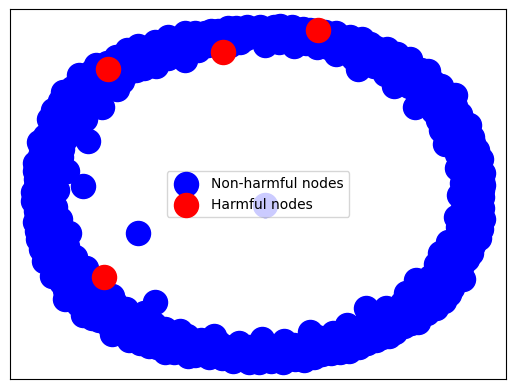

Number of harmful nodes: 4
Number of nodes in subgraph: 536


In [ ]:
import random
import torch
import networkx as nx
import matplotlib.pyplot as plt

num_visualize_nodes = int(0.01 * len(G.nodes))
visualize_nodes = random.sample(list(G.nodes()), num_visualize_nodes)

# Create a subgraph with the selected nodes
subgraph = G.subgraph(visualize_nodes)

# Visualization
pos = nx.spring_layout(subgraph)  # Layout for positioning nodes

# Draw non-harmful nodes in blue
non_harmful_nodes = [node for node in subgraph.nodes if 'harmful' not in subgraph.nodes[node]]
nx.draw_networkx_nodes(subgraph, pos, nodelist=non_harmful_nodes, node_color='blue', label='Non-harmful nodes')

# Draw harmful nodes in red
harmful_nodes_in_subgraph = [node for node in subgraph.nodes if 'harmful' in subgraph.nodes[node]]
nx.draw_networkx_nodes(subgraph, pos, nodelist=harmful_nodes_in_subgraph, node_color='red', label='Harmful nodes')

# # Draw edges
# nx.draw_networkx_edges(subgraph, pos)


# Add legend
plt.legend()

# Show the plot
plt.show()

# Print the number of harmful nodes identified
print(f"Number of harmful nodes: {len(harmful_nodes_in_subgraph)}")
print(f"Number of nodes in subgraph: {len(subgraph)}")

In [ ]:
print("Harmful nodes:", harmful_nodes)
print(len(harmful_nodes))

Harmful nodes: ['495366618818830336', '520284654755381249', '505369323922522113', '530017051025604609', '489798752438583297', '356407105953071107', '529747368087126019', '560442390805090307', '364383457545162754', '542423103834296323', '535507913226190849', '504433135036407808', '521727831307722753', '553184482241814530', '489902412900343809', '560873850846846978', '516804849619705859', '489798752358916096', '489796088338341888', '511330322831507456', '554343513887105024', '514540926640087040', '677950378785271808', '357300409292959744', '523123023646175233', '364589696573124609', '514429381737852929', '365056836476481537', '489818014364086273', '348209998565879810', '489796998615547904', '524646141938647043', '534303066867367937', '513015596879867904', '505611045897924608', '524317344730869760', '519868410599993344', '520132836594970625', '336913656921083904', '387233034350514176', '532106726539939841', '531833233143783424', '372901260183494656', '514512849876836352', '491200302365040

In [ ]:
import random

sampled_harmful_nodes = random.sample(harmful_nodes, int(0.05 * len(harmful_nodes)))

sample_size = int(0.05 * len(G.nodes))
sampled_nodes = random.sample(G.nodes(), sample_size)

# Ensure all sampled_harmful_nodes are included in sampled_nodes
for node in sampled_harmful_nodes:
    if node not in sampled_nodes:
        sampled_nodes.append(node)

# Create a subgraph with the sampled nodes
sampled_subgraph = G.subgraph(sampled_nodes).copy()

# Ensure the subgraph is undirected for the immunization algorithm
sampled_subgraph = sampled_subgraph.to_undirected()

<ipython-input-98-fac4e81640a8>:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(G.nodes(), sample_size)


In [ ]:

import itertools
from heapq import *

class PriorityQueue:
    def __init__(self, initlist=[]):
        self.counter = itertools.count()  # unique sequence count
        self.entry_finder = {}  # mapping of tasks to entries
        self.pq = []
        for el in initlist:
            entry = [-el[0], next(self.counter), el[1]]
            self.pq.append(entry)
            self.entry_finder[el[1]] = entry
        heapify(self.pq)  # list of entries arranged in a heap
        self.REMOVED = '<removed-task>'  # placeholder for a removed task

    def update_task_add(self, task, add_value):
        priority = 0
        if task in self.entry_finder:
            entry = self.entry_finder.pop(task)
            entry[-1] = self.REMOVED
            priority = entry[0]
        count = next(self.counter)
        entry = [priority-add_value, count, task]
        self.entry_finder[task] = entry
        heappush(self.pq, entry)

    def add_task(self, task, priority=0):
        'Add a new task or update the priority of an existing task'
        if task in self.entry_finder:
            self.remove_task(task)
        count = next(self.counter)
        entry = [-priority, count, task]
        self.entry_finder[task] = entry
        heappush(self.pq, entry)

    def remove_task(self, task):
        'Mark an existing task as REMOVED.  Raise KeyError if not found.'
        entry = self.entry_finder.pop(task)
        entry[-1] = self.REMOVED

    def pop_task(self):
        'Remove and return the lowest priority task. Raise KeyError if empty.'
        while self.pq:
            priority, count, task = heappop(self.pq)
            if task is not self.REMOVED:
                del self.entry_finder[task]
                return task
        raise KeyError('pop from an empty priority queue')

In [ ]:
import time

class Solver:
    def __init__(self, G, k, **params):
        if len(G) == 0:
            raise Exception("Graph can not be empty")
        # if len(seeds) == 0:
        #     raise Exception("Seeds can not be empty")
        # if k > len(G) - len(seeds):
        #     raise Exception("Seeds can not be blocked: too large k")
        if k == 0:
            raise Exception("k should be greater than 0")
        self.G = G.copy()
        # self.seeds = [int(node) for node in seeds]
        self.k = int(k)
        self.log = {}
        self.log['created'] = time.time()
        self.params = params
        self.clear()

    def clear(self):
        pass

    def get_name(self):
        return self.__class__.__name__

## Sparse shield

In [ ]:
import networkx as nx
import time

from scipy.sparse.linalg import eigsh
from heapq import *
class SparseShieldSolver(Solver):
    def sparse_shield(self):
        G = self.G.to_undirected()
        nodelist = list(G.nodes())
        M = len(G)
        indexes = list(range(M))
        inverse_index = {nodelist[i]: i for i in indexes}

        t1 = time.time()
        A = nx.to_scipy_sparse_array(G, nodelist=nodelist, weight=None, dtype='f')
        W, V = eigsh(A, k=1, which='LM')
        max_eig = W[0]
        max_eigvec = V[:, 0].reshape((V.shape[0],))

        self.log["Eigenvalue"] = max_eig

        harmful_nodes = {node for node in G.nodes if G.nodes[node].get('harmful', False)}

        pk = PriorityQueue()
        for i, node in enumerate(nodelist):
            score = 2 * max_eig * (max_eigvec[i] ** 2)
            # If the node is harmful, assign it a lower priority
            if node in harmful_nodes:
                score *= 0.5
            pk.add_task(i, score)

        S = set()
        while len(S) < self.k and len(pk.pq) > 0:
            next_best = pk.pop_task()
            node_index = next_best
            is_harmful = node_index in harmful_nodes
            if not is_harmful:
                S.add(node_index)
                for n in G.neighbors(nodelist[node_index]):
                    j = inverse_index[n]
                    if j not in S:
                        pk.add_task(j, -2 * max_eigvec[node_index] * max_eigvec[j])

        t2 = time.time()
        self.log['Total time'] = t2 - t1

        return [nodelist[i] for i in S]

    def run(self):
        blocked = self.sparse_shield()
        self.log['Blocked nodes'] = [str(node) for node in blocked]
        return blocked

k = int(0.05 * len(sampled_subgraph.nodes))  # Adjust k as needed

# Instantiate and run the solver on the sampled subgraph
solver = SparseShieldSolver(sampled_subgraph, k)
blocked_nodes = solver.run()

# Mark the blocked nodes in the sampled subgraph
for node in blocked_nodes:
    sampled_subgraph.nodes[node]['immunized'] = True

print(f"Blocked nodes: {blocked_nodes}")

print(len(sampled_subgraph))
print(len(blocked_nodes))

Blocked nodes: ['538853908227977219', '534445263528947712', '691007605565722624', '543095582144090113', '692763861691305985', '767528171520524288', '523820806917603328', '766020195676778497', '755523466791489536', '538292829597237248', '694245599235948544', '692456850831204352', '489865454312099840', '690431187916099584', '570405783306944514', '693187271516909568', '500394061887709184', '532695511737049088', '543587608362614785', '780883700921667584', '757450526153900032', '538374385665449985', '690137637810761728', '265957600154230784', '552661209204260864', '499689772928204800', '80080680482123777', '665498651742085124', '555022000486236160', '547554298465628160', '387036965339938817', '516396443247312896', '489798752438583297', '537006518118273025', '265955609944420353', '523863683928457216', '692032162212757506', '683731779342188545', '692472216135569409', '535489942810787840', '519868864101122048', '692838477914705921', '504106473467944960', '686421576904916992', '5501766973715988

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import numpy as np
import warnings
from joblib import Parallel, delayed
import random

class Simulator:
    def __init__(self, G, seeds):
        self.G = G
        self.seeds = seeds
        self.blocked = {}
        self.log = {}

    def add_blocked(self, name, node_set):
        self.blocked[name] = list(node_set)

    def run(self, iterations, num_threads=22):
        assert(sum([not self.G.has_node(n) for n in self.seeds]) == 0)
        for key in self.blocked:
            blocked_list = self.blocked[key]
            # any blocked or seed node should exist in the graph
            assert(sum([not self.G.has_node(n) for n in blocked_list]) == 0)
        self.log['iterations'] = iterations
        iteration_results = []
        results = Parallel(n_jobs=num_threads)(
            delayed(self.run_iteration)() for i in range(iterations))
        for result in results:
            iteration_results.append(result)
        self.log.update(
            self.merge_results_across_iterations(iteration_results))
        return self.log

    def run_iteration(self):
        return self.simuation_as_possible_world()

    def simuation_as_possible_world(self):
        t1 = time.time()
        front_nodes = self.seeds
        active_series = []
        active_series.append(len(front_nodes))
        active = set()
        active.update(self.seeds)

        iterations = 0
        active_edges = set()
        active_subgraph = nx.DiGraph()
        active_subgraph.add_nodes_from([key for key in active])

        while len(front_nodes) > 0:
            front_edges = self.get_front_edges(front_nodes)
            active_edges.update(front_edges)
            front_nodes = [e[1] for e in front_edges if e[1] not in active]
            active.update(front_nodes)
            active_series.append(active_series[-1] + len(front_nodes))
            iterations += 1

        active_subgraph.add_edges_from(active_edges)
        results = {}
        results['iterations until termination in unblocked graph'] = iterations
        results['active nodes in unblocked graph'] = len(active_subgraph)
        results['active series in unblocked graph'] = active_series
        results['solvers'] = {}
        for blocked_set_name in self.blocked:
            blocked_list = self.blocked[blocked_set_name]
            results['solvers'][blocked_set_name] = {}
            active_subgraph_with_blocked = active_subgraph.subgraph(
                [node for node in active_subgraph.nodes() if node not in blocked_list])
            active_subgraph_with_blocked = self.get_reachable_subgraph_from_seeds(
                active_subgraph_with_blocked)
            activated_node_amount = len(active_subgraph_with_blocked)
            saved_node_amount = results['active nodes in unblocked graph'] - \
                activated_node_amount
            results['solvers'][blocked_set_name]['activated nodes'] = activated_node_amount
            results['solvers'][blocked_set_name]['saved nodes'] = saved_node_amount
            results['solvers'][blocked_set_name]['fraction of saved nodes to active nodes'] = saved_node_amount / \
                results['active nodes in unblocked graph']
            results['solvers'][blocked_set_name]['active series in blocked graph'] = self.get_active_series_with_blocked(
                active_subgraph, blocked_list)
        t2 = time.time()
        results['simulation time'] = t2 - t1
        return results

    def get_reachable_subgraph_from_seeds(self, G):
        G = G.copy()
        G.add_node("superseed")
        G.add_edges_from([("superseed", n) for n in self.seeds])
        node_subset = nx.descendants(G, "superseed")
        return G.subgraph(node_subset - set(["superseed"]))

    def get_front_edges(self, front_nodes):
        new_front_edges = []
        for v in front_nodes:
            for u in self.G.neighbors(v):
                weight = self.G[v][u].get('weight', 1.0)  # Use 1.0 as default weight
                if np.random.rand() <= weight:
                    new_front_edges.append((v, u))
        return new_front_edges

    def get_active_series_with_blocked(self, active_subgraph, blocked_list):
        front_nodes = self.seeds
        active = set(self.seeds)
        active_series = [len(active)]

        while len(front_nodes) > 0:
            front_edges = [(v, u) for v in front_nodes for u in self.G.neighbors(v) if u not in active and u not in blocked_list]
            front_nodes = [e[1] for e in front_edges]
            active.update(front_nodes)
            active_series.append(len(active))

        return active_series

    def merge_results_across_iterations(self, results):
        assert(len(results) > 0)
        r = results[0]
        N = len(results)
        merged = {}
        for key in r:
            if key == "solvers":
                continue
            merged[key] = self.get_list_stats(
                [results[i][key] for i in range(N)])
        merged['solvers'] = {}
        for alg in r['solvers']:
            merged['solvers'][alg] = {}
            for key in r['solvers'][alg]:
                l = [results[i]['solvers'][alg][key] for i in range(N)]
                merged['solvers'][alg][key] = self.get_list_stats(
                    [results[i]['solvers'][alg][key] for i in range(N)])
        merged['active series in unblocked graph'] = self.get_list_stats(
            [results[i]['active series in unblocked graph'] for i in range(N)])
        return merged

    def get_list_stats(self, l):
        s = {}
        warnings.simplefilter("ignore", category=RuntimeWarning)
        s['mean'] = np.mean(l, axis=0)
        s['var'] = np.var(l, ddof=1, axis=0)
        return s

    def plot_simulation_results(self):
        plt.figure(figsize=(12, 6))

        # Plot active series for the unblocked graph
        active_series_unblocked = self.log['active series in unblocked graph']['mean']
        plt.plot(active_series_unblocked, label='Unblocked Graph')

        # Plot active series for the blocked graphs
        for blocked_set_name in self.blocked:
            active_series_blocked = self.log['solvers'][blocked_set_name]['active series in blocked graph']['mean']
            plt.plot(active_series_blocked, label=f'Blocked Graph ({blocked_set_name})')

        plt.xlabel('Iterations')
        plt.ylabel('Number of Active Nodes')
        plt.title('Simulation of Information Spread')
        plt.legend()
        plt.show()


Simulation results: {'iterations': 50, 'iterations until termination in unblocked graph': {'mean': 2.0, 'var': 0.0}, 'active nodes in unblocked graph': {'mean': 32.0, 'var': 0.0}, 'active series in unblocked graph': {'mean': array([17., 32., 32.]), 'var': array([0., 0., 0.])}, 'simulation time': {'mean': 0.0010620594024658204, 'var': 2.957478166220482e-08}, 'solvers': {'SparseShield': {'activated nodes': {'mean': 18.0, 'var': 0.0}, 'saved nodes': {'mean': 14.0, 'var': 0.0}, 'fraction of saved nodes to active nodes': {'mean': 0.4375, 'var': 0.0}, 'active series in blocked graph': {'mean': array([17., 28., 28.]), 'var': array([0., 0., 0.])}}}}


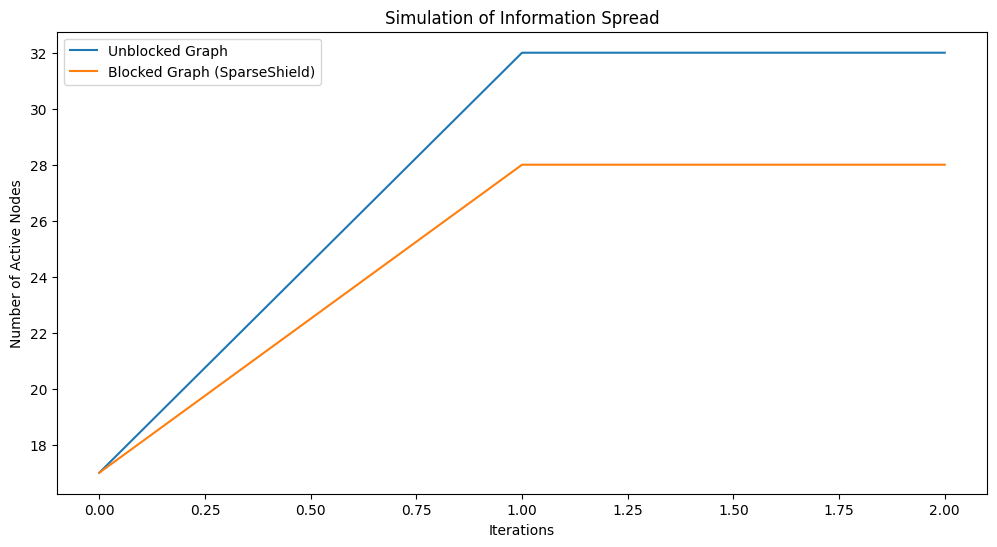

In [ ]:

simulator = Simulator(sampled_subgraph, sampled_harmful_nodes)
simulator.add_blocked("SparseShield", blocked_nodes)

# Run the simulation
simulation_results = simulator.run(iterations=50)

# Print simulation results
print(f"Simulation results: {simulation_results}")
simulator.plot_simulation_results()

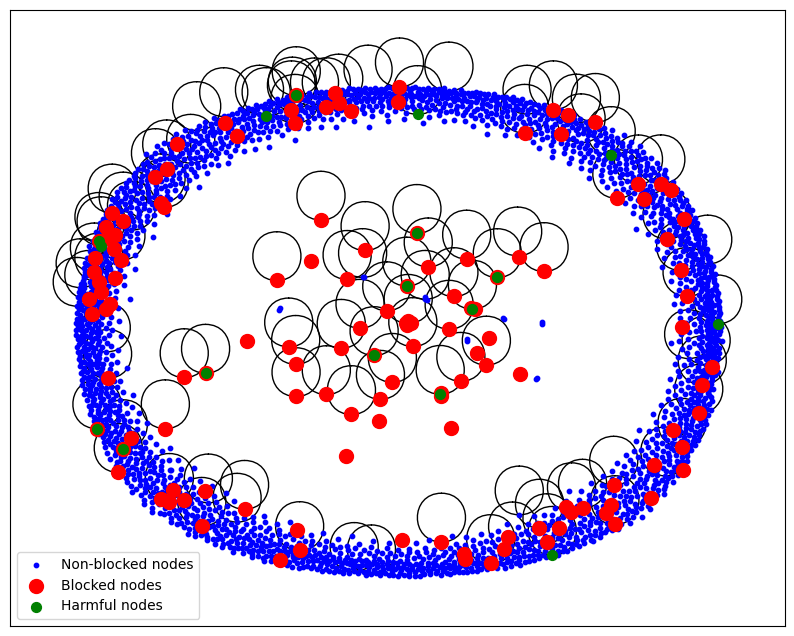

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming `sampled_subgraph` is your subgraph and `simulator` is an instance of Simulator

# Extract blocked nodes from simulator.blocked
blocked_nodes = set()
for key in simulator.blocked:
    blocked_nodes.update(simulator.blocked[key])

# Nodes that are not blocked
non_blocked_nodes = [node for node in sampled_subgraph.nodes if node not in blocked_nodes]

# Create a layout for the graph
pos = nx.spring_layout(sampled_subgraph)

# Visualization
plt.figure(figsize=(10, 8))

# Draw non-blocked nodes in blue
nx.draw_networkx_nodes(sampled_subgraph, pos=pos, nodelist=non_blocked_nodes, node_color='blue', label='Non-blocked nodes',  node_size=10)

# Draw blocked nodes in red
nx.draw_networkx_nodes(sampled_subgraph, pos=pos, nodelist=blocked_nodes, node_color='red', label='Blocked nodes',  node_size=100)

nx.draw_networkx_nodes(sampled_subgraph, pos=pos, nodelist=sampled_harmful_nodes, node_color='green', label='Harmful nodes',  node_size=50)


# Draw edges
nx.draw_networkx_edges(sampled_subgraph, pos=pos)

# Draw labels (assuming nodes have labels)

# Add legend
plt.legend()

# Show the plot
plt.show()


## Random Solver

In [ ]:
class RandomSolver(Solver):
    def __init__(self, G, k, seeds):
        super().__init__(G, k)
        self.seeds = seeds

    def run(self):
        t1 = time.time()
        random_blocked_set = np.random.choice([node for node in self.G.nodes() if node not in self.seeds], self.k, replace=False)
        t2 = time.time()

        self.log['Total time'] = (t2-t1)
        self.log['Blocked nodes'] = [str(node) for node in random_blocked_set]
        return random_blocked_set

In [ ]:
k = int(0.05 * len(sampled_subgraph.nodes))
solver = RandomSolver(sampled_subgraph, k, sampled_harmful_nodes)
blocked_nodes = solver.run()

# Mark the blocked nodes in the sampled subgraph
for node in blocked_nodes:
    sampled_subgraph.nodes[node]['immunized'] = True

print(f"Blocked nodes: {blocked_nodes}")

Blocked nodes: ['688834298493800448' '516043973329432576' '697811457207996416'
 '532330906854232064' '523489852181184513' '689853056440221696'
 '767800459557953536' '690177514409463808' '553502308739600385'
 '552571287558971394' '549610282906296320' '553503544280875008'
 '529171556098768897' '427764695198871552' '749571223114223616'
 '524232007975710720' '523672527760281600' '543594981022121984'
 '514452623068766209' '764847942519824385' '504483498762063872'
 '559582618891468800' '525024066152169473' '747277654995329025'
 '682560856425664512' '693238613669081088' '693132433416425472'
 '528243837345738752' '766315027494240257' '514115395088035840'
 '506905794508759040' '693739163041054721' '765923451232260096'
 '727839335232380928' '765325277996130305' '715521003468640256'
 '516382125185302529' '724388866866614272' '716128880856162304'
 '517478750527553536' '689655074310631424' '767223774072676354'
 '563187522457858049' '531660834620334081' '517721099908698113'
 '749288769136627712' '51

Simulation results: {'iterations': 50, 'iterations until termination in unblocked graph': {'mean': 2.0, 'var': 0.0}, 'active nodes in unblocked graph': {'mean': 39.0, 'var': 0.0}, 'active series in unblocked graph': {'mean': array([17., 39., 39.]), 'var': array([0., 0., 0.])}, 'simulation time': {'mean': 0.001093449592590332, 'var': 8.566215476966302e-08}, 'solvers': {'RandomSolver': {'activated nodes': {'mean': 38.0, 'var': 0.0}, 'saved nodes': {'mean': 1.0, 'var': 0.0}, 'fraction of saved nodes to active nodes': {'mean': 0.025641025641025633, 'var': 4.913086592824581e-35}, 'active series in blocked graph': {'mean': array([17., 38., 38.]), 'var': array([0., 0., 0.])}}}}


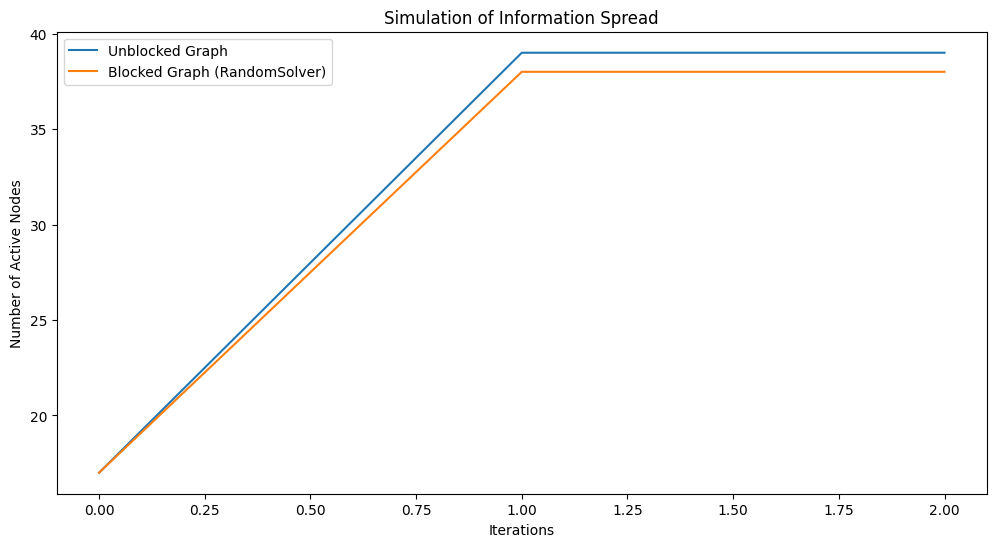

In [ ]:
simulator = Simulator(sampled_subgraph, sampled_harmful_nodes)
simulator.add_blocked("RandomSolver", blocked_nodes)

# Run the simulation
simulation_results = simulator.run(iterations=50)

# Print simulation results
print(f"Simulation results: {simulation_results}")
simulator.plot_simulation_results()

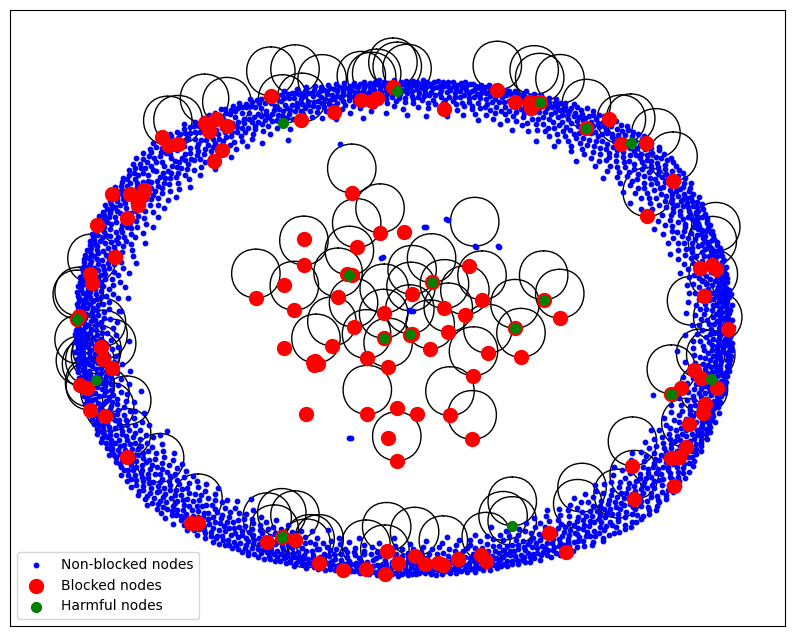

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


# Extract blocked nodes from simulator.blocked
blocked_nodes = set()
for key in simulator.blocked:
    blocked_nodes.update(simulator.blocked[key])

# Nodes that are not blocked
non_blocked_nodes = [node for node in sampled_subgraph.nodes if node not in blocked_nodes]

# Create a layout for the graph
pos = nx.spring_layout(sampled_subgraph)

# Visualization
plt.figure(figsize=(10, 8))

# Draw non-blocked nodes in blue
nx.draw_networkx_nodes(sampled_subgraph, pos=pos, nodelist=non_blocked_nodes, node_color='blue', label='Non-blocked nodes',  node_size=10)

# Draw blocked nodes in red
nx.draw_networkx_nodes(sampled_subgraph, pos=pos, nodelist=blocked_nodes, node_color='red', label='Blocked nodes',  node_size=100)

nx.draw_networkx_nodes(sampled_subgraph, pos=pos, nodelist=sampled_harmful_nodes, node_color='green', label='Harmful nodes',  node_size=50)


# Draw edges
nx.draw_networkx_edges(sampled_subgraph, pos=pos)

# Draw labels (assuming nodes have labels)

# Add legend
plt.legend()

# Show the plot
plt.show()


## Netshield Solver

In [ ]:
from scipy.linalg import eigh
class NetShieldSolver(Solver):

    def net_shield(self):
        G = self.G.to_undirected()
        nodelist = [n for n in G.nodes()]
        inverse_index = {}
        for i in range(len(nodelist)):
            inverse_index[nodelist[i]] = i

        t1 = time.time()
        A = nx.to_numpy_matrix(G, nodelist=nodelist, weight=None)
        M = len(G)
        W, V = eigh(A, eigvals=(M-1, M-1), type=1, overwrite_a=True)
        max_eig = W[0]
        max_eigvec = V[:,0].reshape((V.shape[0],))

        self.log["Eigenvalue"] = max_eig


        harmful_nodes = {node for node in G.nodes if G.nodes[node].get('harmful', False)}

        pk = PriorityQueue()
        for i, node in enumerate(nodelist):
            score = 2 * max_eig * (max_eigvec[i] ** 2)
            # If the node is harmful, assign it a lower priority
            if node in harmful_nodes:
                score *= 0.5
            pk.add_task(i, score)

        S = set()
        for it in range(self.k):
            next_best = pk.pop_task()
            S.add(next_best)
            for n in G.neighbors(nodelist[next_best]):
                j = inverse_index[n]
                if j not in S:
                    pk.update_task_add(j, -2 * max_eigvec[next_best] * max_eigvec[j])

        t2 = time.time()
        self.log['Total time'] = t2-t1

        return [nodelist[i] for i in S]

    def run(self):
        blocked = self.net_shield()
        self.log['Blocked nodes'] = [str(node) for node in blocked]
        return blocked

In [ ]:
k = int(0.05 * len(sampled_subgraph.nodes))

solver = NetShieldSolver(sampled_subgraph, k)
blocked_nodes = solver.run()

# Mark the blocked nodes in the sampled subgraph
for node in blocked_nodes:
    sampled_subgraph.nodes[node]['immunized'] = True

print(f"Blocked nodes: {blocked_nodes}")
print(len(blocked_nodes))

<ipython-input-80-1d45b30410e0>:14: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  W, V = eigh(A, eigvals=(M-1, M-1), type=1, overwrite_a=True)


Blocked nodes: ['436167837527203840', '514097549532467201', '765934702381371392', '524232110727385088', '524996674838876160', '501835828436299776', '552615631246622721', '537454231595536384', '766123096637968384', '516371936604352513', '525024066152169473', '531206654013231104', '524992169485271040', '531665774336020480', '532298833309347840', '531649134948655104', '501760566160289794', '555088259806928897', '765863022506151937', '692134252083806213', '504203396715671552', '537383351037227010', '513820566172614656', '524997452093337601', '524950264303075328', '767307412785160192', '387294440663953408', '501794565829824513', '501832459190009856', '514098833253748736', '528796379943297024', '531660097647562752', '692816356337528832', '560156576749584384', '505369323922522113', '504244463678791681', '715000710870482945', '766130130053980162', '436352836109357056', '334778867426422784', '504133163832983552', '518665533089406976', '555015085395963905', '519713142046068736', '514617995000561

Simulation results: {'iterations': 10, 'iterations until termination in unblocked graph': {'mean': 2.0, 'var': 0.0}, 'active nodes in unblocked graph': {'mean': 39.0, 'var': 0.0}, 'active series in unblocked graph': {'mean': array([17., 39., 39.]), 'var': array([0., 0., 0.])}, 'simulation time': {'mean': 0.0009786844253540038, 'var': 5.8377186304723074e-08}, 'solvers': {'NetShieldSolver': {'activated nodes': {'mean': 28.0, 'var': 0.0}, 'saved nodes': {'mean': 11.0, 'var': 0.0}, 'fraction of saved nodes to active nodes': {'mean': 0.28205128205128205, 'var': 0.0}, 'active series in blocked graph': {'mean': array([17., 31., 31.]), 'var': array([0., 0., 0.])}}}}


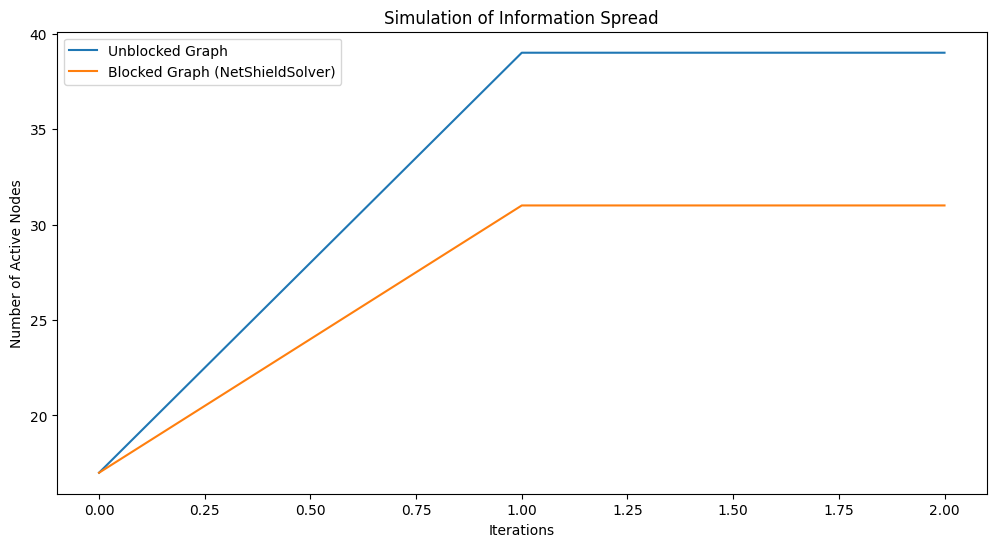

{'iterations': 10, 'iterations until termination in unblocked graph': {'mean': 2.0, 'var': 0.0}, 'active nodes in unblocked graph': {'mean': 39.0, 'var': 0.0}, 'active series in unblocked graph': {'mean': array([17., 39., 39.]), 'var': array([0., 0., 0.])}, 'simulation time': {'mean': 0.0009786844253540038, 'var': 5.8377186304723074e-08}, 'solvers': {'NetShieldSolver': {'activated nodes': {'mean': 28.0, 'var': 0.0}, 'saved nodes': {'mean': 11.0, 'var': 0.0}, 'fraction of saved nodes to active nodes': {'mean': 0.28205128205128205, 'var': 0.0}, 'active series in blocked graph': {'mean': array([17., 31., 31.]), 'var': array([0., 0., 0.])}}}}


In [ ]:
simulator = Simulator(sampled_subgraph, sampled_harmful_nodes)
simulator.add_blocked("NetShieldSolver", blocked_nodes)

# Run the simulation
simulation_results = simulator.run(iterations=10)

# Print simulation results
print(f"Simulation results: {simulation_results}")
simulator.plot_simulation_results()
print(simulator.log)

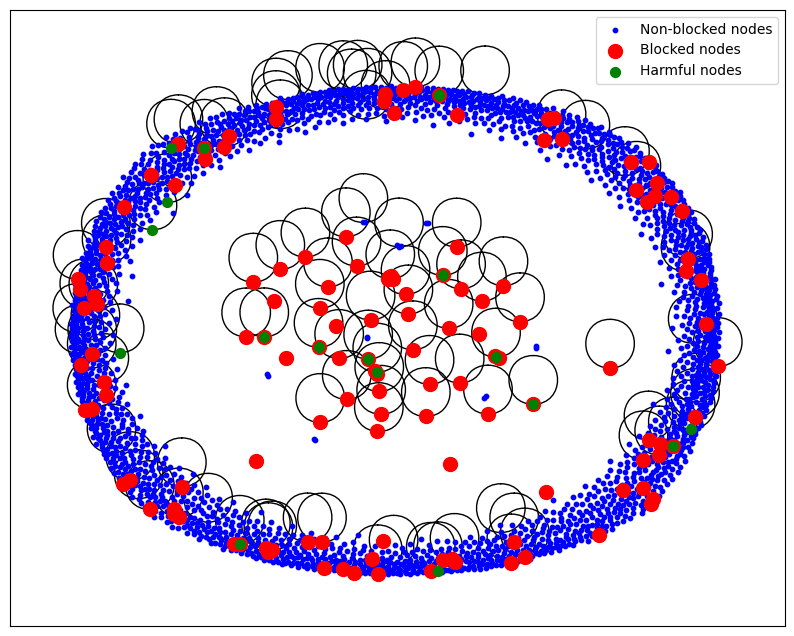

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming `sampled_subgraph` is your subgraph and `simulator` is an instance of Simulator

# Extract blocked nodes from simulator.blocked
blocked_nodes = set()
for key in simulator.blocked:
    blocked_nodes.update(simulator.blocked[key])

# Nodes that are not blocked
non_blocked_nodes = [node for node in sampled_subgraph.nodes if node not in blocked_nodes]

# Create a layout for the graph
pos = nx.spring_layout(sampled_subgraph)

# Visualization
plt.figure(figsize=(10, 8))

# Draw non-blocked nodes in blue
nx.draw_networkx_nodes(sampled_subgraph, pos=pos, nodelist=non_blocked_nodes, node_color='blue', label='Non-blocked nodes',  node_size=10)

# Draw blocked nodes in red
nx.draw_networkx_nodes(sampled_subgraph, pos=pos, nodelist=blocked_nodes, node_color='red', label='Blocked nodes',  node_size=100)

nx.draw_networkx_nodes(sampled_subgraph, pos=pos, nodelist=sampled_harmful_nodes, node_color='green', label='Harmful nodes',  node_size=50)


# Draw edges
nx.draw_networkx_edges(sampled_subgraph, pos=pos)


# Add legend
plt.legend()

# Show the plot
plt.show()
